## Import Libraries

In [1]:
import numpy as np 
import healpy as hp
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
import glob
import seaborn as sns
sns.set_style("darkgrid")
# sns.set(rc={"xtick.bottom": True, "ytick.left": True})
%matplotlib inline

## Reading GEOTIFF map into a HEALPix array

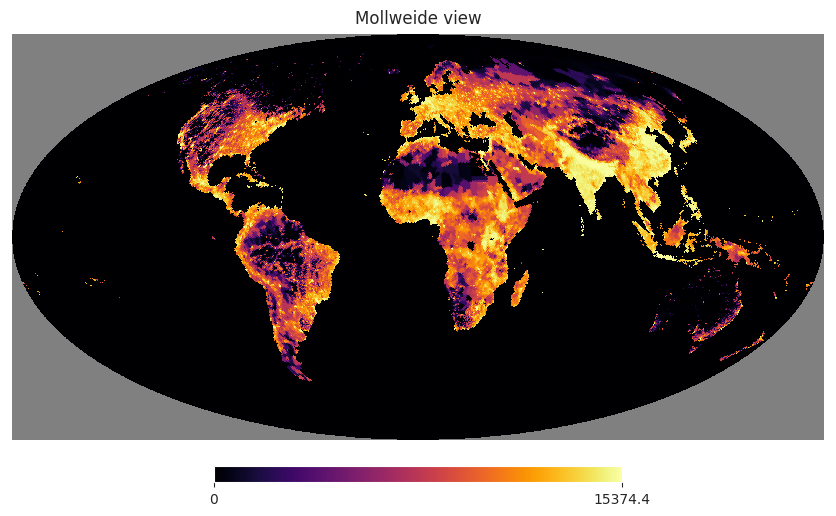

In [2]:
##---------Read the tif file---------##
image = tiff.imread('/media/sf_Shared_Ubuntu/MAPS/gpw_v4_population_density_adjusted_to_2015_unwpp_country_totals_rev11_2020_15_min.tif')
image_array = np.array(image)


#----------Define the spherical coordinates----------#
theta = np.linspace(np.radians(0), np.radians(180), num=image_array.shape[0],endpoint=False)
phi = np.linspace(-np.radians(180), np.radians(180), num=image_array.shape[1],endpoint=False)

#---------- Set angular resolution----------#
nside = 128

##--------Make empty healpix mask and pixel values vector--------##
healpix_map = np.zeros(hp.nside2npix(nside), dtype=np.double)
pixel_counts = np.zeros(hp.nside2npix(nside), dtype=int)


for i in range(len(theta)):
    for j in range(len(phi)):
        pixel = hp.ang2pix(nside, theta[i], phi[j])
        healpix_map[pixel] += image_array[i, j]
        pixel_counts[pixel] += 1

#--------Average value of each pixel--------#
healpix_map[pixel_counts>0] /= pixel_counts[pixel_counts>0 ]


hp.mollview(healpix_map, cmap="inferno", xsize=3000, flip="geo", norm="hist", min=0)
plt.show()

In [3]:
csv_files = glob.glob('./database/*.csv')

# Exclude the "Brazil.csv" file from the list
csv_files = [file for file in csv_files if not file.endswith('Brazil.csv')]




# Create an empty dataframe to store the combined data
combined_df = pd.DataFrame()

# Loop through each CSV file and append its contents to the combined dataframe
for csv_file in (csv_files):
    df_temp = pd.read_csv(csv_file)
    combined_df = pd.concat([combined_df, df_temp])

# Print the combined dataframe
lat_128=combined_df['Latitude in degrees'].to_numpy()
lon_128=combined_df['Longitude in degrees'].to_numpy()
power_128=combined_df['EIRP'].to_numpy()
pixel_128=hp.ang2pix(128,lon_128,lat_128,lonlat=True)

## Num of Tx map

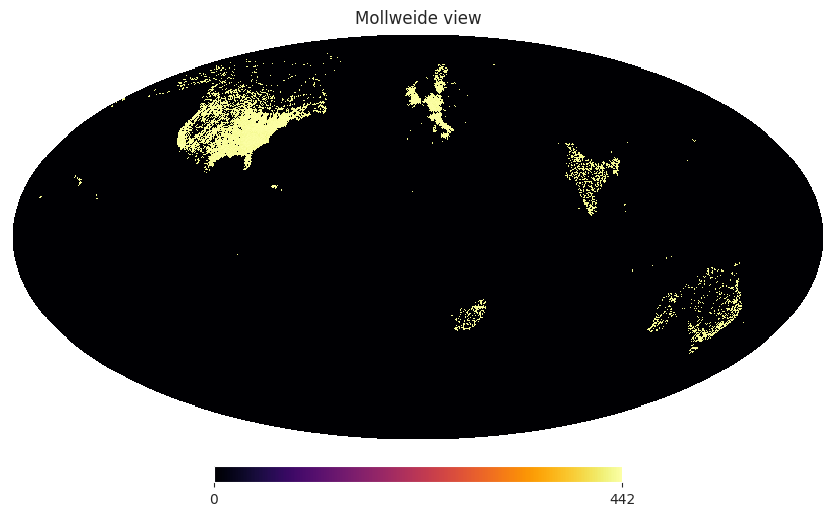

In [4]:
Tx_num_128=np.zeros(hp.nside2npix(128))
for pix in pixel_128:
    Tx_num_128[pix]+=1
hp.mollview(Tx_num_128,flip='geo',min=0,cmap='inferno',norm='hist')
plt.show()

## Tx power map

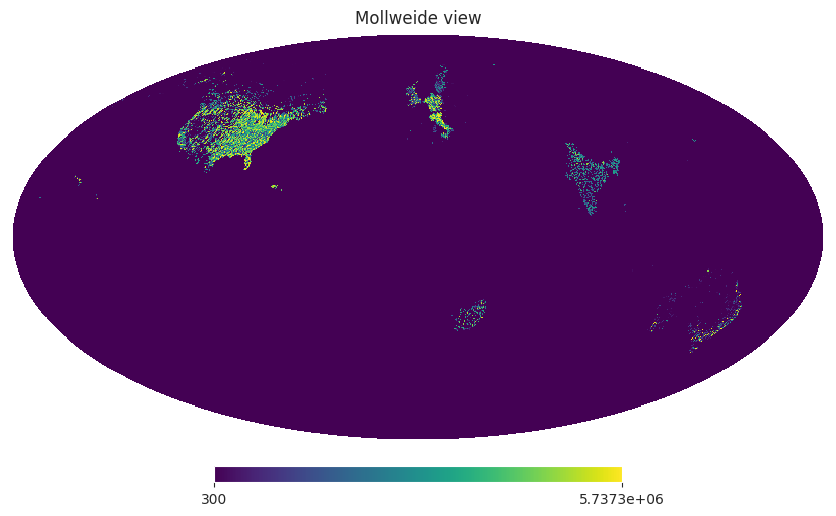

In [5]:
Tx_pow_128=np.zeros(hp.nside2npix(128))
for index,p in enumerate(pixel_128):
    Tx_pow_128[p]+=(power_128[index])
hp.mollview(Tx_pow_128,flip='geo',min=3*10**2,cmap='viridis',norm='hist')
plt.show()

In [6]:
healpix_map[healpix_map<1e-5]=0
x_=healpix_map
y_=Tx_pow_128
fin_val_index=(x_>0)&(y_>0)

## Color coded plot

In [7]:
file_paths = csv_files 

selected_indices_list = []
color = []


for file_path in file_paths:
    df = pd.read_csv(file_path)
    lon = df['Longitude in degrees'].to_numpy()
    lat = df['Latitude in degrees'].to_numpy()
    selected_indices = hp.ang2pix(128, lon, lat, lonlat=True)
    selected_indices_list.append(selected_indices)

# Loop through the pixels in x_
for pix, _ in enumerate(x_):
    for i, selected_indices in enumerate(selected_indices_list):
        if pix in selected_indices:
            color.append(["red","green","blue","yellow","pink","black","orange","purple","beige","brown","gray","cyan","magenta"][i])
            break
    else:
        color.append('w')


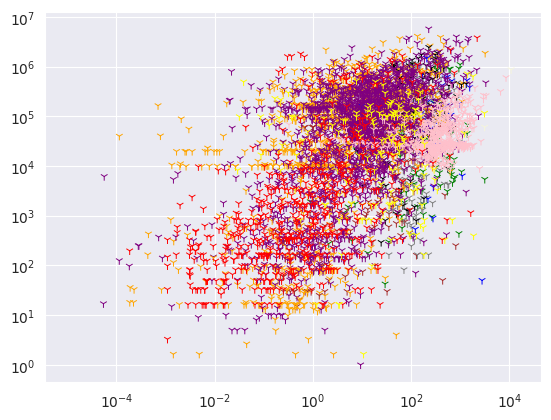

In [8]:
plt.scatter(x_,y_,c=color,marker='1',linewidths=0.7)

plt.xscale('log')
plt.yscale('log')

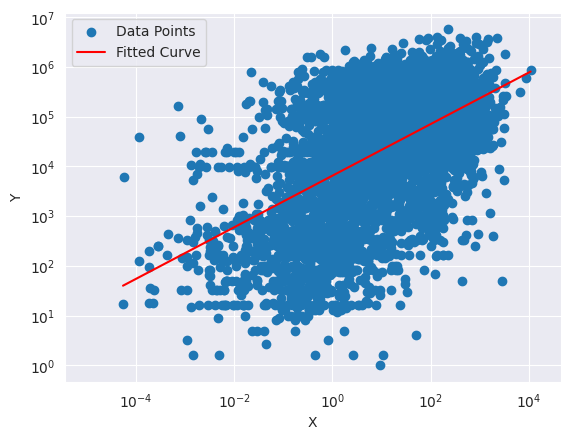

In [9]:
x_log = np.log10(x_[fin_val_index])
y_log = np.log10(y_[fin_val_index])

deg=1
coefficients = np.polyfit(x_log, y_log,deg ) 

# Create a polynomial function using the coefficients
poly = np.poly1d(coefficients)

# Generate x values for the fitted curve in log space
xfit_log = np.linspace(np.min(x_log), np.max(x_log), 100)

# Calculate y values for the fitted curve in log space using the polynomial function
yfit_log = poly(xfit_log)

# Transform the xfit_log and yfit_log back to the original scale
xfit = 10**(xfit_log)
yfit = 10**(yfit_log)

# Plot the data points and the fitted curve
plt.scatter(x_, y_, label='Data Points')
plt.plot(xfit, yfit, label='Fitted Curve', color='red')
plt.legend()
plt.xscale('log'),plt.yscale('log')
plt.xlabel('X')
plt.ylabel('Y')
plt.yscale('log')  # Set the y-axis to log scale
plt.show()



In [10]:
new_pwr_map=poly(np.log10(healpix_map))
new_pwr_map**=10
np.min(new_pwr_map)

/tmp/ipykernel_3877/3916690209.py:1: RuntimeWarning: divide by zero encountered in log10
  new_pwr_map=poly(np.log10(healpix_map))
/home/yogen14/.local/lib/python3.10/site-packages/numpy/lib/polynomial.py:780: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv


nan

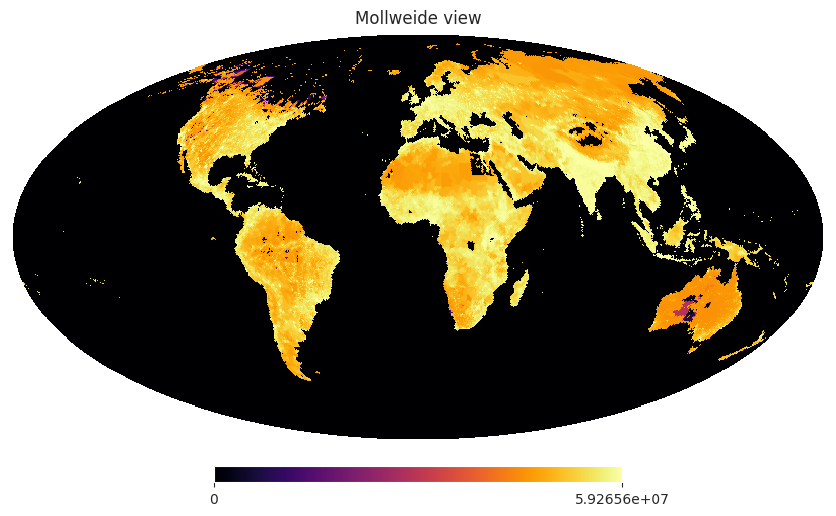

In [11]:
new_pwr_map=np.nan_to_num(new_pwr_map)
hp.mollview(new_pwr_map,flip='geo',cmap='inferno',norm='hist')
plt.show()

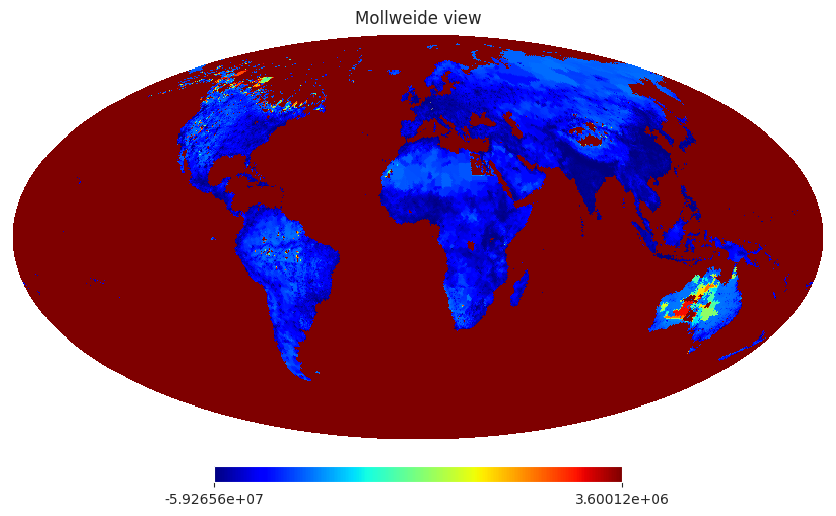

In [12]:

diff=Tx_pow_128-new_pwr_map
difmap=np.zeros(hp.nside2npix(128))
difmap+=diff
# difmap/=1e6
hp.mollview(difmap,flip='geo',cmap='jet',norm='hist')

(array([2.00000e+00, 8.00000e+00, 5.00000e+00, 2.50000e+01, 6.40000e+01,
        2.56000e+02, 9.16000e+02, 3.36400e+03, 1.45100e+04, 1.77454e+05]),
 array([-59265571.23398691, -52979002.01058821, -46692432.78718953,
        -40405863.56379084, -34119294.34039214, -27832725.11699345,
        -21546155.89359476, -15259586.67019607,  -8973017.44679738,
         -2686448.22339869,   3600121.        ]),
 <BarContainer object of 10 artists>)

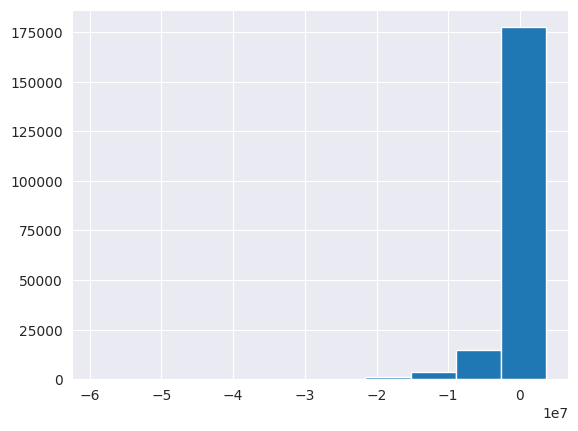

In [13]:
plt.hist(diff)